In [179]:
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.features import load_trips, remove_outliers


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    style="whitegrid",
    context="talk",
    rc=rc
)
sns.set_color_codes()

pd.set_option('display.max_columns', None)

# Load data

In [20]:
# %time tmp = load_trips(['M3_VH', 'M3_HH', 'CPH1_HH', 'CPH1_VH', 'CPH6_VH', 'CPH6_HH'], trips='all', sampling='2s')
# %time tmp = load_trips(['CPH6_VH', 'CPH6_HH', 'M3_VH', 'CPH1_VH', 'CPH1_HH'], trips='all', sampling='2s')
# df = tmp

df = pd.read_parquet('../data/processed/all_data.parquet')

In [21]:
outlier_columns = ['acceleration_z',
                   'acceleration_y',
                   'acceleration_x',
                   'steering_position',
                   'steering_acceleration',
                   'traction_instant_consumption',
                   'yaw_rate',
                   'velocity']

df = remove_outliers(df, outlier_columns)
df = df.sort_index()

# Longitudinal acceleration

In [132]:
melt_cols = ['acceleration_x', 'acceleration_y', 'velocity']
id_cols = df.drop(melt_cols, axis=1).columns.tolist() + ['TS_or_Distance']

df_plot = pd.melt(df.reset_index(), id_cols, melt_cols, value_name='value', var_name='type')
df_plot = df_plot[(df_plot.TS_or_Distance > "2021-04-22 12:35") & (df_plot.TS_or_Distance < "2021-04-22 13:00")]

In [133]:
fig = px.line(df_plot, x='TS_or_Distance', y='value', facet_row='type')

fig.update_yaxes(matches=None, showticklabels=True, visible=True)

['CPH1_VH']


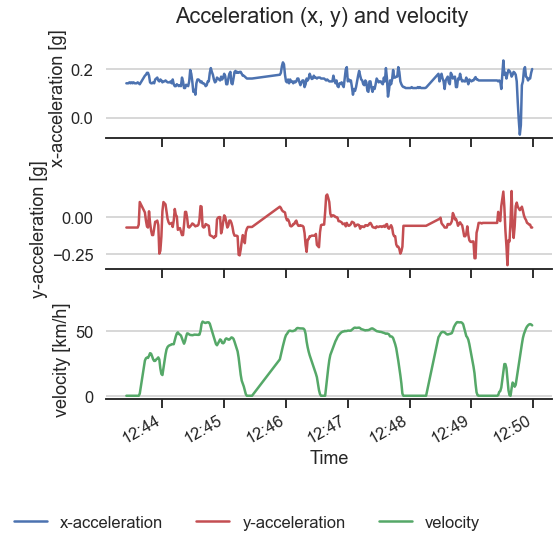

In [282]:
df_plot = df.copy()
df_plot = df_plot[(df_plot.index > "2021-04-22 12:43") & (df_plot.index < "2021-04-22 12:50")]
fig, [ax0, ax1, ax2] = plt.subplots(3, 1, sharex=True, figsize=[8.0, 7.0])

sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_x', label='x-acceleration', ax=ax0, legend=False, color='b')
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', label='y-acceleration', ax=ax1, legend=False, color='r')
sns.lineplot(data=df_plot, x='TS_or_Distance', y='velocity', label='velocity', ax=ax2, legend=False, color='g')

fig.suptitle('Acceleration (x, y) and velocity')
plt.xlabel('Time')
ax0.set_ylabel('x-acceleration [g]')
ax1.set_ylabel('y-acceleration [g]')
ax2.set_ylabel('velocity [km/h]')

# plt.legend(bbox_to_anchor=(1.1, -0.15), ncol=6)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(.8, 0), ncol=3)

fig.autofmt_xdate()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.subplots_adjust(hspace=0.6)
plt.savefig('../figures/acceleration_velocity.png', bbox_inches='tight')
plt.show()

X axis is turning, Y axis is acceleration and deceleration

# Feature engineering

## Moving Average

To adjust for sensor inaccuracy

In [191]:
trips = df.trip.unique()

for trip in trips:
    df.loc[df.trip == trip, 'acceleration_y_mean'] = df.query(f'trip == {trip}')['acceleration_y'].rolling('10min').mean()
    df.loc[df.trip == trip, 'acceleration_x_mean'] = df.query(f'trip == {trip}')['acceleration_x'].rolling('10min').mean()

In [101]:
df_plot.astype('category')

segment_id    GPS_dt    lat_int    lon_int  \
TS_or_Distance                                                           
2021-04-13 05:15:00+00:00     0.800000  2.453196  55.683103  12.585212   
2021-04-13 05:20:00+00:00   366.318841  0.482779  55.677714  12.587249   
2021-04-13 05:25:00+00:00  1188.871186  0.505563  55.662187  12.594265   
2021-04-13 05:30:00+00:00  1735.823944  0.732408  55.645948  12.591844   
2021-04-13 05:35:00+00:00  1815.750000  1.308250  55.644024  12.591578   
...                                ...       ...        ...        ...   
2021-08-27 11:15:00+00:00   590.716327  1.420016  55.662841  12.532404   
2021-08-27 11:20:00+00:00   832.829966  1.094071  55.660198  12.502202   
2021-08-27 11:25:00+00:00   664.774757  1.754905  55.655561  12.487348   
2021-08-27 11:30:00+00:00   540.354402  1.191230  55.648592  12.502261   
2021-08-27 11:35:00+00:00   496.690678  1.229326  55.667253  12.517346   

                          acceleration_z acceleration_y acceleration_x  \
TS_or_Distance                                                           
2021-04-13 05:15:00+00:00       0.996100      -0.058600       0.148400   
2021-04-13 05:20:00+00:00       0.994015      -0.057612       0.162201   
2021-04-13 05:25:00+00:00       0.994896      -0.058432       0.150402   
2021-04-13 05:30:00+00:00       0.990139      -0.074178       0.168590   
2021-04-13 05:35:00+00:00       0.984400      -0.050312       0.219287   
...                                  ...            ...            ...   
2021-08-27 11:15:00+00:00       0.963633       0.139469       0.095408   
2021-08-27 11:20:00+00:00       0.963300       0.133182       0.094024   
2021-08-27 11:25:00+00:00       0.964641       0.130660       0.087767   
2021-08-27 11:30:00+00:00       0.962867       0.134740       0.094345   
2021-08-27 11:35:00+00:00       0.961610       0.135148       0.111631   

                          steering_position steering_acceleration  \
TS_or_Distance                                                      
2021-04-13 05:15:00+00:00      32906.000000          32767.000000   
2021-04-13 05:20:00+00:00      32660.726449          32771.637681   
2021-04-13 05:25:00+00:00      32720.476271          32766.186441   
2021-04-13 05:30:00+00:00      32911.640845          32772.070423   
2021-04-13 05:35:00+00:00      33309.000000          32767.000000   
...                                     ...                   ...   
2021-08-27 11:15:00+00:00      32789.134694          32764.469388   
2021-08-27 11:20:00+00:00      32817.335017          32766.292929   
2021-08-27 11:25:00+00:00      32789.434951          32766.126214   
2021-08-27 11:30:00+00:00      32844.933409          32766.932280   
2021-08-27 11:35:00+00:00      32839.658898          32768.949153   

                          traction_instant_consumption    yaw_rate   velocity  \
TS_or_Distance                                                                  
2021-04-13 05:15:00+00:00                     0.000000  204.620000   0.000000   
2021-04-13 05:20:00+00:00                     2.862319  204.216123  24.513913   
2021-04-13 05:25:00+00:00                     2.676271  204.437119  28.124966   
2021-04-13 05:30:00+00:00                     1.204225  204.525352  32.813028   
2021-04-13 05:35:00+00:00                     0.000000  204.575000   0.000000   
...                                                ...         ...        ...   
2021-08-27 11:15:00+00:00                     2.085714  204.682449  18.324041   
2021-08-27 11:20:00+00:00                     2.380471  204.649327  25.943569   
2021-08-27 11:25:00+00:00                     1.598058  204.792621   9.379767   
2021-08-27 11:30:00+00:00                     4.356659  204.904515  41.981129   
2021-08-27 11:35:00+00:00                     2.690678  204.527119  27.252564   

                               odometer front_wiper_status  \
TS_or_Distance                                               
2021-04-13 05:15:00+00:00 

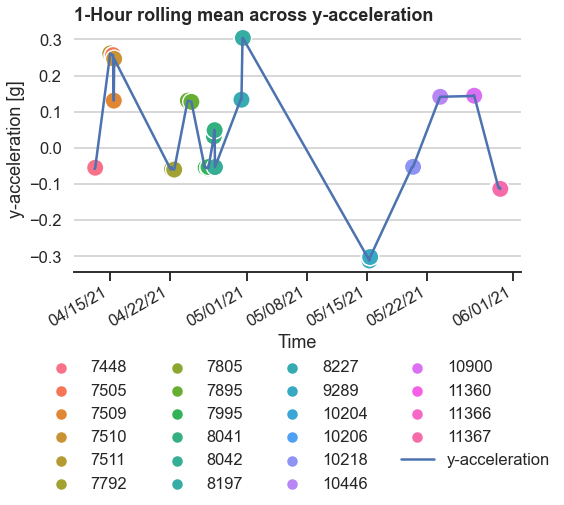

In [269]:
df_plot = df.copy()
df_plot = df_plot[(df_plot.index > "2021-04-12 12:00") & (df_plot.index < "2021-05-30 13:00")]

# fig = plt.figure(figsize=(12, 8))
df_plot = df_plot.resample('1h').mean()
df_plot = df_plot.dropna()
df_plot['trip'] = df_plot['trip'].apply(lambda x: int(np.floor(x)))
df_plot['trip'] = df_plot['trip'].astype('category')

fig, ax = plt.subplots(1, 1)

sns.scatterplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', hue='trip', s=300, legend=True, ax=ax)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', label='y-acceleration', ax=ax)
# sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_mean', label='2-minute mean acceleration')

plt.title('1-Hour rolling mean across y-acceleration')
plt.xlabel('Time')
plt.ylabel('y-acceleration [g]')
plt.legend(bbox_to_anchor=(1.1, -0.3), ncol=4)

fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

plt.savefig('../figures/offset_raw.png', bbox_inches='tight')
plt.show()

C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\1767237971.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



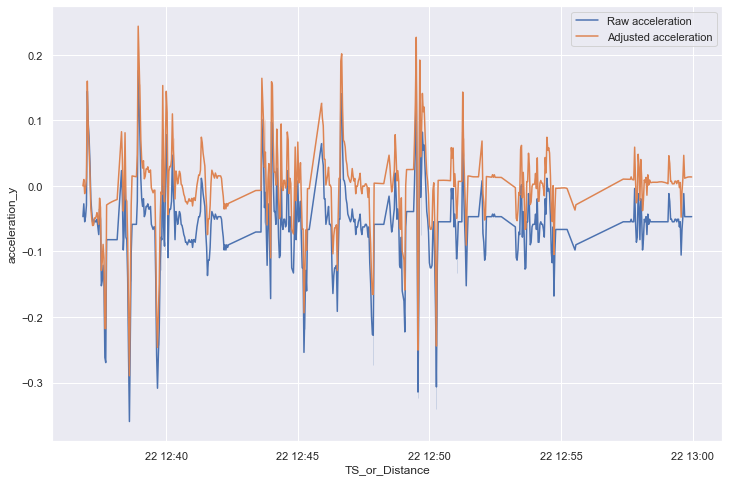

In [54]:
df_plot['adjusted_acceleration_y'] = df_plot['acceleration_y'] - df_plot['acceleration_y_mean']

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', label='Raw acceleration')
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='Adjusted acceleration')

plt.legend()
fig.show()

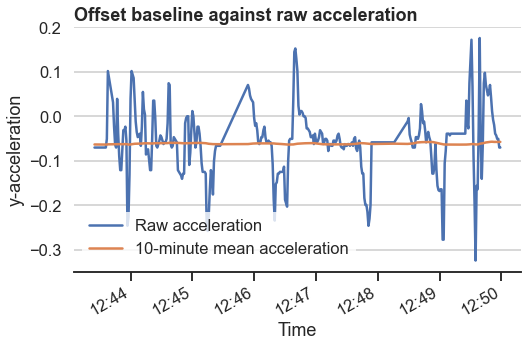

In [274]:
df_plot = df.copy()
# df_plot = df_plot[(df_plot.TS_or_Distance > "2021-04-22 12:00") & (df_plot.TS_or_Distance < "2021-04-22 13:00")]
df_plot = df_plot[(df_plot.index > "2021-04-22 12:43") & (df_plot.index < "2021-04-22 12:50")]

fig, ax = plt.subplots(1, 1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', label='Raw acceleration', ax=ax)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_mean', label='10-minute mean acceleration', ax=ax)


fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend()
plt.title('Offset baseline against raw acceleration')
plt.ylabel('y-acceleration')
plt.xlabel('Time')
plt.savefig('../figures/offset_value.png', bbox_inches='tight')
fig.show()

In [56]:
df_plot.adjusted_acceleration_y.mean()

-0.0010426087789271092

In [97]:
df_plot.acceleration_y_mean.df_plot()

In [ ]:
df_plot.adjusted_acceleration_y.df_plot()

In [206]:
df['adjusted_acceleration_y'] = df['acceleration_y'] - df['acceleration_y_mean']
df['adjusted_acceleration_x'] = df['acceleration_x'] - df['acceleration_x_mean']

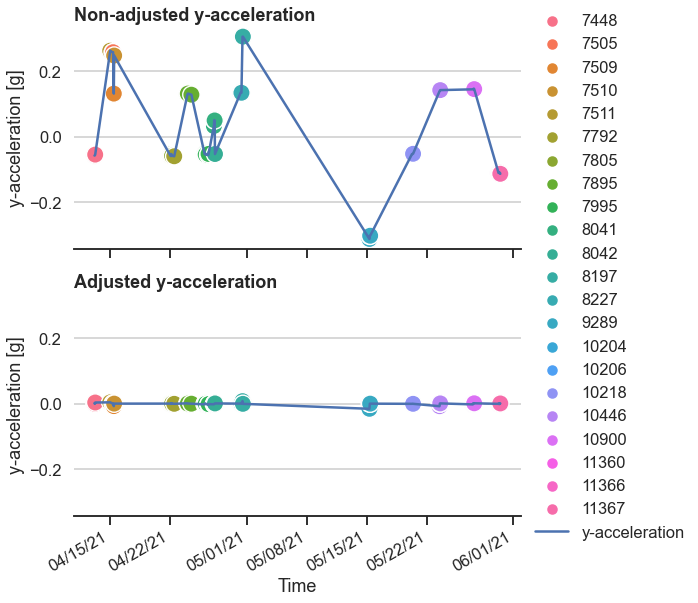

In [273]:
df_plot = df.copy()
df_plot = df_plot[(df_plot.index > "2021-04-12 12:00") & (df_plot.index < "2021-05-30 13:00")]

# fig = plt.figure(figsize=(12, 8))
df_plot = df_plot.resample('1h').mean()
df_plot = df_plot.dropna()
df_plot['trip'] = df_plot['trip'].apply(lambda x: int(np.floor(x)))
df_plot['trip'] = df_plot['trip'].astype('category')

fig, [ax0, ax1] = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 10))

sns.scatterplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', hue='trip', s=300, legend=False, ax=ax0)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y', label='y-acceleration', ax=ax0)

sns.scatterplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', hue='trip', s=300, legend=True, ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='y-acceleration', ax=ax1)
# sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_mean', label='2-minute mean acceleration')

ax0.set_title('Non-adjusted y-acceleration')
ax1.set_title('Adjusted y-acceleration')

ax1.set_xlabel('Time')
ax0.set_ylabel('y-acceleration [g]')
ax1.set_ylabel('y-acceleration [g]')

ax0.legend([])
ax1.legend(bbox_to_anchor=(1, 2.325), ncol=1)
# plt.ylim([-0.305, 0.3])

fig.autofmt_xdate()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

plt.savefig('../figures/offset_adjusted_y.png', bbox_inches='tight')
plt.show()

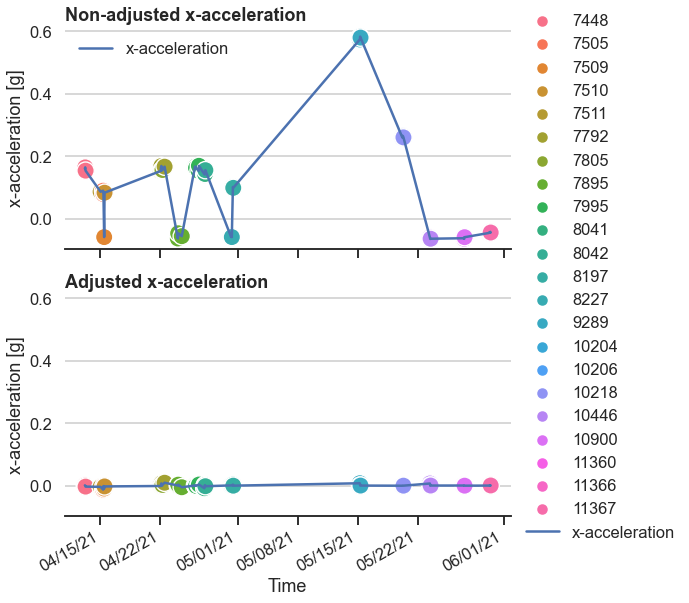

In [272]:
df_plot = df.copy()
df_plot = df_plot[(df_plot.index > "2021-04-12 12:00") & (df_plot.index < "2021-05-30 13:00")]

# fig = plt.figure(figsize=(12, 8))
df_plot = df_plot.resample('1h').mean()
df_plot = df_plot.dropna()
df_plot['trip'] = df_plot['trip'].apply(lambda x: int(np.floor(x)))
df_plot['trip'] = df_plot['trip'].astype('category')

fig, [ax0, ax1] = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 10))

sns.scatterplot(data=df_plot, x='TS_or_Distance', y='acceleration_x', hue='trip', s=300, legend=False, ax=ax0)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_x', label='x-acceleration', ax=ax0)

sns.scatterplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_x', hue='trip', s=300, legend=True, ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_x', label='x-acceleration', ax=ax1)
# sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_mean', label='2-minute mean acceleration')

ax0.set_title('Non-adjusted x-acceleration')
ax1.set_title('Adjusted x-acceleration')

ax1.set_xlabel('Time')
ax0.set_ylabel('x-acceleration [g]')
ax1.set_ylabel('x-acceleration [g]')

# ax0.legend([])
ax1.legend(bbox_to_anchor=(1, 2.325), ncol=1)
# plt.ylim([-0.305, 0.3])

fig.autofmt_xdate()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

plt.savefig('../figures/offset_adjusted_x.png', bbox_inches='tight')
plt.show()

In [264]:
df['adjusted_acceleration_x'].std()

0.03998479808883285

In [265]:
df['acceleration_x'].std()

0.16160498531006337

In [ ]:
# Speeding if exceeds by 5%
df['is_speeding'] = df['velocity'] > (df['speed_limit'] * 1.05)

### Acceleration

In [283]:
# Acceleration

# Car 0-50 km/h in seconds
# https://www.renaultgroup.com/en/news-on-air/news/the-renault-zoe-motor-energy-efficiency-and-power/#:~:text=It%20has%20a%20torque%20of,h%20takes%20just%206.5%20seconds.
zero_to_50_s = 3.5

meters = 50 * 1000
# m / s^2 = (m / s) * (1 / zero_to_100)
max_acceleration = (meters / 3600) / zero_to_50_s

# Acceleration in g's
max_acc_gs = max_acceleration / 9.82

print(f'Maximum acceleration [g] = {max_acc_gs:.3f}')

In [284]:
df.adjusted_acceleration_y.describe()

In [285]:
# Acceleration

# Car 0-50 km/h in seconds
# https://www.renaultgroup.com/en/news-on-air/news/the-renault-zoe-motor-energy-efficiency-and-power/#:~:text=It%20has%20a%20torque%20of,h%20takes%20just%206.5%20seconds.
zero_to_50_s = 3.5

meters = 50 * 1000
# m / s^2 = (m / s) * (1 / zero_to_100)
max_acceleration = (meters / 3600) / zero_to_50_s

# Acceleration in g's
max_acc_gs = max_acceleration / 9.81

print(f'Maximum acceleration [g] = {max_acc_gs:.3f}')

Maximum acceleration [g] = 0.405


In [286]:
# Define hard acceleration as anything equal or above 80% of max
df['is_hard_acceleration'] = df['adjusted_acceleration_y'] >= (max_acc_gs * 0.80)

# Define medium acceleration as anything equal or above 50% of max and below 80%
df['is_medium_acceleration'] = (df['adjusted_acceleration_y'] >= (max_acc_gs * 0.50)) & (
            df['adjusted_acceleration_y'] < (max_acc_gs * 0.8))

# Define easy acceleration as anything below 50% of max and above 20% of max
df['is_soft_acceleration'] = (df['adjusted_acceleration_y'] < (max_acc_gs * 0.5)) & (df['adjusted_acceleration_y'] > (max_acc_gs * 0.2))

count    195858.000000
mean         -0.000190
std           0.063026
min          -0.398153
25%          -0.018775
50%           0.000907
75%           0.020236
max           0.390193
Name: adjusted_acceleration_y, dtype: float64

<AxesSubplot:>

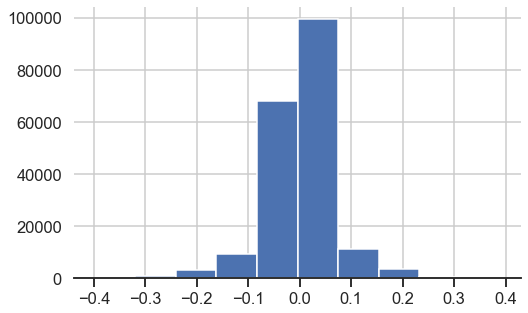

In [287]:
df.value_counts(['is_hard_acceleration', 'is_medium_acceleration', 'is_soft_acceleration'])

In [288]:
df.query('is_hard_acceleration')

In [289]:
df_plot = df[(df.index > "2021-04-22 05:20") & (df.index < "2021-04-22 05:40")]

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='Acceleration y')
sns.scatterplot(data=df_plot.query('is_soft_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Soft acceleration', color='green', s=50)
sns.scatterplot(data=df_plot.query('is_medium_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Medium acceleration', color='orange', s=50)
sns.scatterplot(data=df_plot.query('is_hard_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Hard acceleration', color='red', s=50)

plt.legend()
plt.show()

is_hard_acceleration  is_medium_acceleration  is_soft_acceleration
False                 False                   False                   182456
                                              True                     11785
                      True                    False                     1556
True                  False                   False                       61
dtype: int64

### Braking

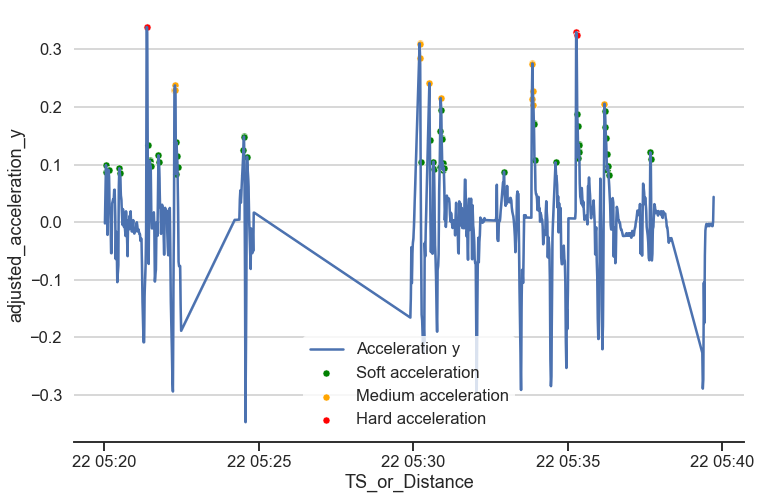

In [290]:
# Define hard braking as anything equal or above 80% of max
df['is_hard_braking'] = -df['adjusted_acceleration_y'] >= (max_acc_gs * 0.80)

# Define medium braking as anything equal or above 50% of max and below 80%
df['is_medium_braking'] = (-df['adjusted_acceleration_y'] >= (max_acc_gs * 0.50)) & (-df['adjusted_acceleration_y'] < (max_acc_gs * 0.8))

# Define easy braking as anything below 50% of max and above 20% of max
df['is_soft_braking'] = (-df['adjusted_acceleration_y'] < (max_acc_gs * 0.5)) & (-df['adjusted_acceleration_y'] > (max_acc_gs * 0.2))

In [82]:
df.value_counts(['is_hard_braking', 'is_medium_braking', 'is_soft_braking'])

is_hard_braking  is_medium_braking  is_soft_braking
False            False              False              96447
                                    True                6499
                 True               False                958
True             False              False                 48
dtype: int64

In [291]:
df.query('is_hard_braking')

In [292]:
df_plot = df[(df.index > "2021-04-22 05:09") & (df.index < "2021-04-22 05:25")]

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y')
sns.scatterplot(data=df_plot.query('is_soft_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Soft braking', color='green', s=50)
sns.scatterplot(data=df_plot.query('is_medium_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Medium braking', color='orange', s=50)
sns.scatterplot(data=df_plot.query('is_hard_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Hard braking', color='red', s=50)

plt.legend()
fig.show()

is_hard_braking  is_medium_braking  is_soft_braking
False            False              False              182028
                                    True                11886
                 True               False                1848
True             False              False                  96
dtype: int64

### Turning force

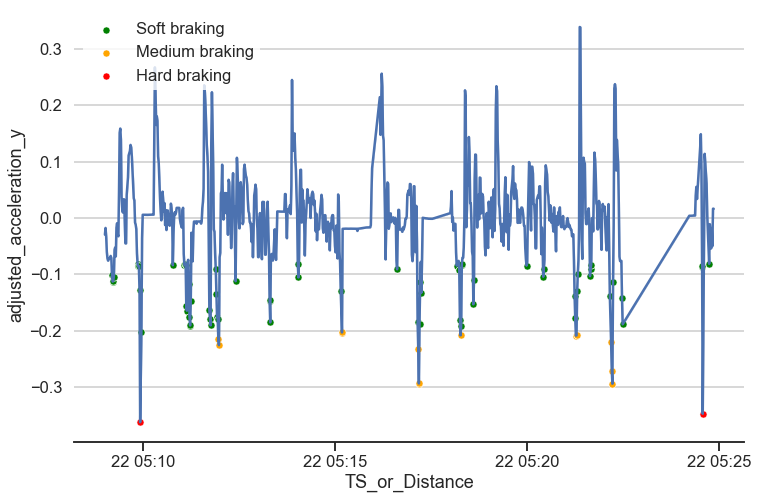

In [293]:
df.adjusted_acceleration_x.describe()

In [308]:
df_plot.route

TS_or_Distance
2021-04-22 05:20:01+00:00    CPH1_VH
2021-04-22 05:20:01+00:00    CPH1_VH
2021-04-22 05:20:02+00:00    CPH1_VH
2021-04-22 05:20:02+00:00    CPH1_VH
2021-04-22 05:20:03+00:00    CPH1_VH
                              ...   
2021-04-22 05:39:39+00:00    CPH1_VH
2021-04-22 05:39:40+00:00    CPH1_VH
2021-04-22 05:39:41+00:00    CPH1_VH
2021-04-22 05:39:42+00:00    CPH1_VH
2021-04-22 05:39:43+00:00    CPH1_VH
Name: route, Length: 1303, dtype: object

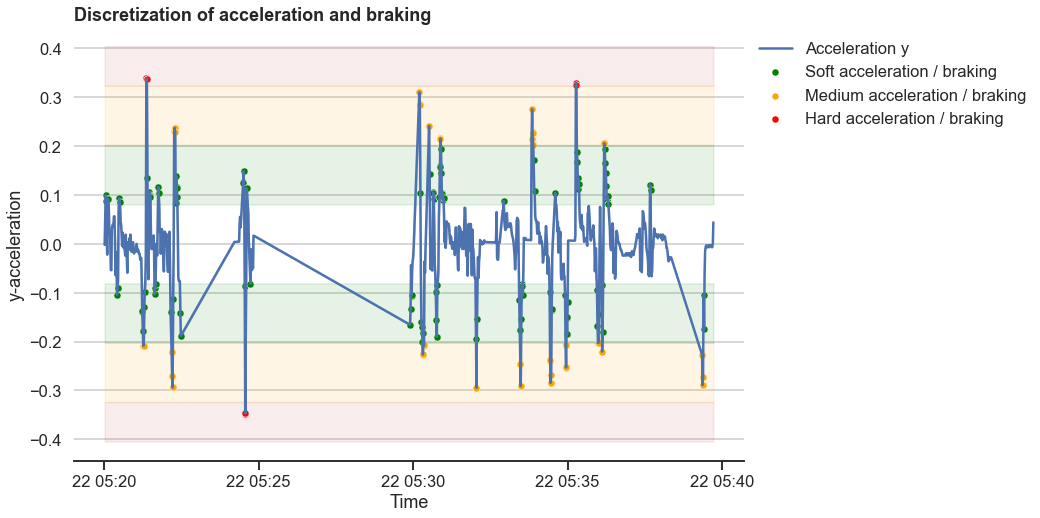

In [305]:
# Combined plot

df_plot = df[(df.index > "2021-04-22 05:20") & (df.index < "2021-04-22 05:40")]

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='Acceleration y')

sns.scatterplot(data=df_plot.query('is_soft_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Soft acceleration / braking', color='green', s=50)
sns.scatterplot(data=df_plot.query('is_medium_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Medium acceleration / braking', color='orange', s=50)
sns.scatterplot(data=df_plot.query('is_hard_acceleration'), x='TS_or_Distance', y='adjusted_acceleration_y',
                label='Hard acceleration / braking', color='red', s=50)

sns.scatterplot(data=df_plot.query('is_soft_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                color='green', s=50, legend=False)
sns.scatterplot(data=df_plot.query('is_medium_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                color='orange', s=50, legend=False)
sns.scatterplot(data=df_plot.query('is_hard_braking'), x='TS_or_Distance', y='adjusted_acceleration_y',
                 color='red', s=50, legend=False)

y_adj = df_plot['adjusted_acceleration_y']
plt.fill_between(x=df_plot.index, y1=max_acc_gs * 0.8, y2=max_acc_gs, alpha=0.1, color='r')
plt.fill_between(x=df_plot.index, y1=max_acc_gs * 0.5, y2=max_acc_gs * 0.8, alpha=0.1, color='orange')
plt.fill_between(x=df_plot.index, y1=max_acc_gs * 0.2, y2=max_acc_gs * 0.5, alpha=0.1, color='green')

plt.fill_between(x=df_plot.index, y1=-max_acc_gs * 0.8, y2=-max_acc_gs, alpha=0.1, color='r')
plt.fill_between(x=df_plot.index, y1=-max_acc_gs * 0.5, y2=-max_acc_gs * 0.8, alpha=0.1, color='orange')
plt.fill_between(x=df_plot.index, y1=-max_acc_gs * 0.2, y2=-max_acc_gs * 0.5, alpha=0.1, color='green')

plt.ylabel('y-acceleration')
plt.xlabel('Time')
plt.title('Discretization of acceleration and braking')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('../figures/discrete_acceleration.png', bbox_inches='tight')
plt.show()

<AxesSubplot:>

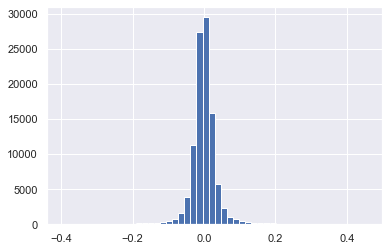

In [100]:
df.adjusted_acceleration_x.hist(bins=50)

<AxesSubplot:>

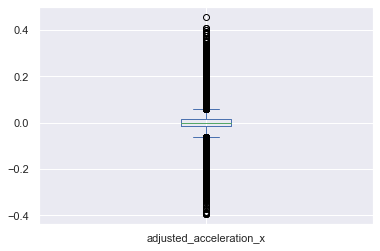

In [114]:
df.adjusted_acceleration_x.plot(kind='box')

In [132]:
# We will use the quantiles of the normal distribution, as we can see it closely follows such. Therefore assumptions hold :) ish
x_acc = df['adjusted_acceleration_x']

# Hard quantiles
q_hard_upper = df.adjusted_acceleration_x.quantile(0.99)
q_hard_lower = df.adjusted_acceleration_x.quantile(0.01)

# Medium quantiles
q_medium_upper = df.adjusted_acceleration_x.quantile(0.975)
q_medium_lower = df.adjusted_acceleration_x.quantile(0.025)

# Soft quantiles
q_soft_upper = df.adjusted_acceleration_x.quantile(0.9)
q_soft_lower = df.adjusted_acceleration_x.quantile(0.1)

df['is_hard_turning'] = (x_acc >= q_hard_upper) | (x_acc <= q_hard_lower)
df['is_medium_turning'] = ((x_acc < q_hard_upper) & (x_acc >= q_medium_upper)) | ((x_acc > q_hard_lower) & (x_acc <= q_medium_lower))
df['is_soft_turning'] = ((x_acc < q_medium_upper) & (x_acc >= q_soft_upper)) | ((x_acc > q_medium_lower) & (x_acc <= q_soft_lower))

In [133]:
df.value_counts(['is_hard_turning','is_medium_turning', 'is_soft_turning'])

is_hard_turning  is_medium_turning  is_soft_turning
False            False              False              83159
                                    True               15595
                 True               False               3118
True             False              False               2080
dtype: int64

In [134]:
df.query('is_hard_turning').head(10)

trip  street_name_start  segment_id  GPS_dt  \
TS_or_Distance                                                             
2021-04-13 05:20:18+00:00  7448.0         Landgreven         7.0   0.328   
2021-04-13 05:20:50+00:00  7448.0  Store Kongensgade        81.0   1.111   
2021-04-13 05:21:20+00:00  7448.0     Kongens Nytorv       155.0   0.297   
2021-04-13 05:23:02+00:00  7448.0      Holmens Kanal       406.0   0.300   
2021-04-13 05:23:20+00:00  7448.0          Børsbroen       466.0   0.288   
2021-04-13 05:23:24+00:00  7448.0           Børsgade       480.0   0.296   
2021-04-13 05:23:32+00:00  7448.0           Børsgade       507.0   0.281   
2021-04-13 05:23:32+00:00  7448.0        Knippelsbro       510.0   0.285   
2021-04-13 05:29:10+00:00  7448.0    Amagerfælledvej      1473.0   0.303   
2021-04-13 05:42:12+00:00  7448.0      Vejlands Allé      2092.0   3.067   

                             lat_int    lon_int  acceleration_z  \
TS_or_Distance                                                    
2021-04-13 05:20:18+00:00  55.683102  12.585216         0.97660   
2021-04-13 05:20:50+00:00  55.682774  12.586432         0.97660   
2021-04-13 05:21:20+00:00  55.681131  12.585034         1.01170   
2021-04-13 05:23:02+00:00  55.677315  12.584639         0.99610   
2021-04-13 05:23:20+00:00  55.675744  12.584724         1.00000   
2021-04-13 05:23:24+00:00  55.675545  12.585095         1.02340   
2021-04-13 05:23:32+00:00  55.675202  12.586483         0.97270   
2021-04-13 05:23:32+00:00  55.675119  12.586619         0.95700   
2021-04-13 05:29:10+00:00  55.655309  12.594090         0.97075   
2021-04-13 05:42:12+00:00  55.640882  12.583758         1.03130   

                           acceleration_y  acceleration_x  yaw_rate  ...  \
TS_or_Distance                                                       ...   
2021-04-13 05:20:18+00:00         0.08785          0.3418    185.80  ...   
2021-04-13 05:20:50+00:00         0.09770          0.3477    184.20  ...   
2021-04-13 05:21:20+00:00        -0.12500         -0.0078    215.90  ...   
2021-04-13 05:23:02+00:00        -0.16020          0.0078    209.50  ...   
2021-04-13 05:23:20+00:00        -0.09770          0.0234    209.20  ...   
2021-04-13 05:23:24+00:00         0.06250          0.0000    210.90  ...   
2021-04-13 05:23:32+00:00        -0.00390          0.3398    198.00  ...   
2021-04-13 05:23:32+00:00         0.04300          0.3828    194.90  ...   
2021-04-13 05:29:10+00:00        -0.00780          0.3125    197.70  ...   
2021-04-13 05:42:12+00:00         0.00390         -0.0664    221.25  ...   

                           is_medium_acceleration  is_soft_acceleration  \
TS_or_Distance                                                            
2021-04-13 05:20:18+00:00                   False                  True   
2021-04-13 05:20:50+00:00                   False                  True   
2021-04-13 05:21:20+00:00                   False                 False   
2021-04-13 05:23:02+00:00                   False                 False   
2021-04-13 05:23:20+00:00                   False                 False   
2021-04-13 05:23:24+00:00                   False                  True   
2021-04-13 05:23:32+00:00                   False                 False   
2021-04-13 05:23:32+00:00                   False                  True   
2021-04-13 05:29:10+00:00                   False                 False   
2021-04-13 05:42:12+00:00                   False                 False   

                           is_hard_braking  is_medium_braking  \
TS_or_Distance                                                  
2021-04-13 05:20:18+00:00            False              False   
2021-04-13 05:20:50+00:00            False              False   
2021-04-13 05:21:20+00:00            False              False   
2021-04-13 05:23:02+00:00            False              False   
2021-04-13 05:23:20+00:00            False              False   
2021-04-13 05:23:24+00:00            False

C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\3688620891.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



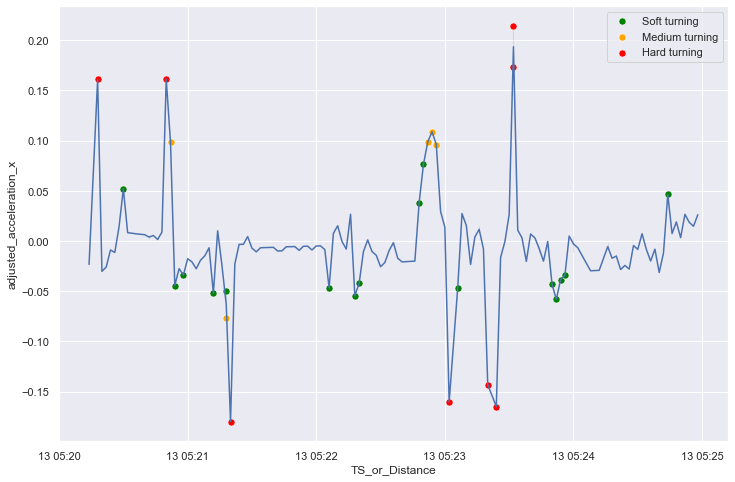

In [135]:
df_plot = df[(df.index > "2021-04-13 05:20") & (df.index < "2021-04-13 05:25")]

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_x')
sns.scatterplot(data=df_plot.query('is_soft_turning'), x='TS_or_Distance', y='adjusted_acceleration_x',
                label='Soft turning', color='green', s=50)
sns.scatterplot(data=df_plot.query('is_medium_turning'), x='TS_or_Distance', y='adjusted_acceleration_x',
                label='Medium turning', color='orange', s=50)
sns.scatterplot(data=df_plot.query('is_hard_turning'), x='TS_or_Distance', y='adjusted_acceleration_x',
                label='Hard turning', color='red', s=50)

plt.legend()
fig.show()

## Window functions

### Rolling Variance

Measure how much a person accelerates or decelerates within a rolling window. Higher frequency of start/stop should weigh higher. The acceleration or deceleration magnitude is captured in the binary variables above.

In [161]:
for trip in trips:
    df.loc[df.trip == trip, 'acceleration_y_var'] = df.query(f'trip == {trip}')['adjusted_acceleration_y'].rolling('3min').var()
    df.loc[df.trip == trip, 'acceleration_x_var'] = df.query(f'trip == {trip}')['adjusted_acceleration_x'].rolling('3min').var()


C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\1560517993.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



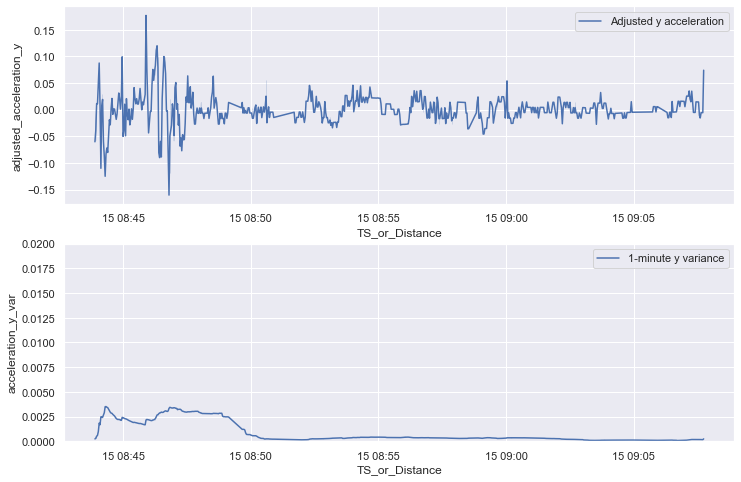

In [158]:
df_plot = df[(df.index > '2021-04-15 08:43') & (df.index < '2021-04-15 09:20')]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='Adjusted y acceleration', ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_var', label='3-minute y variance', ax=ax2)

ax2.set(
    ylim=[0, 0.02]
)

plt.legend()
fig.show()

C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\3396737140.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



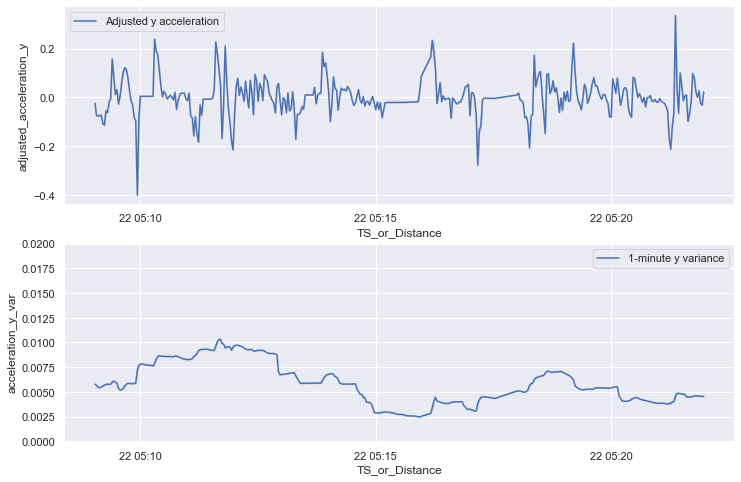

In [160]:
df_plot = df[(df.index > "2021-04-22 05:09") & (df.index < "2021-04-22 05:22")]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_y', label='Adjusted y acceleration', ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_y_var', label='3-minute y variance', ax=ax2)

ax2.set(
    ylim=[0, 0.02]
)

plt.legend()
fig.show()

C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\303445240.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



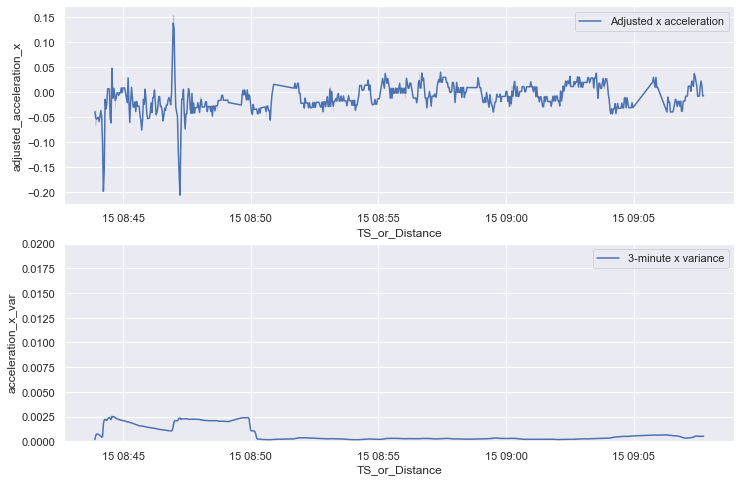

In [162]:
df_plot = df[(df.index > '2021-04-15 08:43') & (df.index < '2021-04-15 09:20')]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_x', label='Adjusted x acceleration', ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_x_var', label='3-minute x variance', ax=ax2)

ax2.set(
    ylim=[0, 0.02]
)

plt.legend()
fig.show()

C:\Users\s174420\AppData\Local\Temp\ipykernel_1236\420690299.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



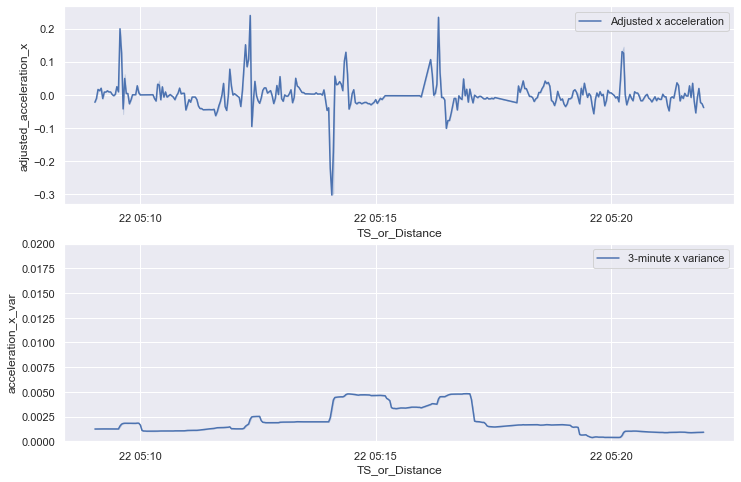

In [163]:
df_plot = df[(df.index > "2021-04-22 05:09") & (df.index < "2021-04-22 05:22")]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(data=df_plot, x='TS_or_Distance', y='adjusted_acceleration_x', label='Adjusted x acceleration', ax=ax1)
sns.lineplot(data=df_plot, x='TS_or_Distance', y='acceleration_x_var', label='3-minute x variance', ax=ax2)

ax2.set(
    ylim=[0, 0.02]
)

plt.legend()
fig.show()

In [174]:
df

trip street_name_start  segment_id    GPS_dt  \
TS_or_Distance                                                               
2021-04-13 05:19:46+00:00   7448.0        Landgreven         0.0  0.797978   
2021-04-13 05:19:48+00:00   7448.0        Landgreven         1.0  2.867000   
2021-04-13 05:19:50+00:00   7448.0        Landgreven         1.0  2.867000   
2021-04-13 05:20:14+00:00   7448.0        Landgreven         3.0  1.090000   
2021-04-13 05:20:18+00:00   7448.0        Landgreven         7.0  0.328000   
...                            ...               ...         ...       ...   
2021-08-27 11:39:50+00:00  13175.0   Søndre Fasanvej       605.0  1.065000   
2021-08-27 11:39:52+00:00  13175.0   Søndre Fasanvej       606.0  4.306000   
2021-08-27 11:39:54+00:00  13175.0   Søndre Fasanvej       606.0  4.306000   
2021-08-27 11:39:56+00:00  13175.0   Søndre Fasanvej       608.0  1.099000   
2021-08-27 11:39:58+00:00  13175.0   Søndre Fasanvej       610.0  1.073000   

                             lat_int    lon_int  acceleration_z  \
TS_or_Distance                                                    
2021-04-13 05:19:46+00:00  55.683107  12.585198          0.9961   
2021-04-13 05:19:48+00:00  55.683102  12.585216          0.9961   
2021-04-13 05:19:50+00:00  55.683102  12.585216          0.9961   
2021-04-13 05:20:14+00:00  55.683102  12.585216          1.0000   
2021-04-13 05:20:18+00:00  55.683102  12.585216          0.9766   
...                              ...        ...             ...   
2021-08-27 11:39:50+00:00  55.675038  12.519554          0.9700   
2021-08-27 11:39:52+00:00  55.675033  12.519553          0.9600   
2021-08-27 11:39:54+00:00  55.675027  12.519550          0.9600   
2021-08-27 11:39:56+00:00  55.675019  12.519546          0.9600   
2021-08-27 11:39:58+00:00  55.675028  12.519550          0.9600   

                           acceleration_y  acceleration_x  yaw_rate  ...  \
TS_or_Distance                                                       ...   
2021-04-13 05:19:46+00:00        -0.05860          0.1484     204.7  ...   
2021-04-13 05:19:48+00:00        -0.05860          0.1484     204.6  ...   
2021-04-13 05:19:50+00:00        -0.05860          0.1484     204.6  ...   
2021-04-13 05:20:14+00:00        -0.05080          0.1172     213.7  ...   
2021-04-13 05:20:18+00:00         0.08785          0.3418     185.8  ...   
...                                   ...             ...       ...  ...   
2021-08-27 11:39:50+00:00         0.12000          0.1100     204.6  ...   
2021-08-27 11:39:52+00:00         0.12000          0.1100     204.6  ...   
2021-08-27 11:39:54+00:00         0.12000          0.1100     204.6  ...   
2021-08-27 11:39:56+00:00         0.12000          0.1100     204.6  ...   
2021-08-27 11:39:58+00:00         0.12000          0.1100     204.6  ...   

                           is_hard_braking  is_medium_braking  \
TS_or_Distance                                                  
2021-04-13 05:19:46+00:00            False              False   
2021-04-13 05:19:48+00:00            False              False   
2021-04-13 05:19:50+00:00            False              False   
2021-04-13 05:20:14+00:00            False              False   
2021-04-13 05:20:18+00:00            False              False   
...                                    ...                ...   
2021-08-27 11:39:50+00:00            False              False   
2021-08-27 11:39:52+00:00            False              False   
2021-08-27 11:39:54+00:00            False              False   
2021-08-27 11:39:56+00:00            False              False   
2021-08-27 11:39:58+00:00            False              False   

                           is_soft_braking  acceleration_x_mean  \
TS_or_Distance                                                    
2021-04-13 05:19:46+00:00            False             0.148400   
2021-04-13 05:19:48+00:00            False             0.148400   
2021-04-13 05:19:50+00:00            Fal